# Analysis of 311 complaints in NYC (NYPD, DEP & HPD)

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
import statsmodels.api as sma
import patsy
import folium
from folium.plugins import HeatMap
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest
import csv
import geopandas as gpd
from statsmodels.graphics.api import abline_plot
%matplotlib inline

### Reading 311 data after 2014, filtering out NYPD complaints and grouping them by months to calculate autocorrelation of number of complaints. Finally saving the complaints and autocorrelation on zip code level

In [24]:
data = pd.read_csv('311After2014NY.csv')

/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (18,19,32,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
nyzips = [10000+i for i in range(1500)]
manzips = [10000+i for i in range(300)]

In [4]:
with open('ComplaintsNYPD_NYC.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    header = ['zip', 'averageComplaintsNYPD', 'autocorr', 'totalComplaints']
    writer.writerow(header)

In [5]:
for zip in nyzips:
    dataTemp = data[(data['Incident Zip'] == zip)]
    
    if len(dataTemp) != 0:
        dataTemp.sort_values(by='Cdate', inplace=True)
    
        y = pd.to_datetime(dataTemp['Cdate'].values)
        dataTemp['month'] = y.strftime("%y-%m")
    
        dataTempNYPD = dataTemp[(dataTemp.Agency == 'NYPD')]
        dataTempNYPD = dataTempNYPD.groupby(by='month').count()
    
        dataTempNYPD['month'] = dataTempNYPD.index
        dataTempNYPD.reset_index(drop=True, inplace=True)
    
        y = dataTempNYPD[['Unique Key']]
    
        totalComplaints = y['Unique Key'].sum()
        avgComplaints = y['Unique Key'].sum()/len(y)
        y['lag'] = y['Unique Key'].shift(1)
    
        y.dropna(inplace=True)
        j = y.corr()
        autocorr = j['lag'][0]
    
        temp = [zip, avgComplaints, autocorr, totalComplaints]
    
        with open('ComplaintsNYPD_NYC.csv', 'a') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(temp)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/lib/python2.7/site-packages/ipy

In [4]:
nyNYPD = pd.read_csv('ComplaintsNYPD_NYC.csv')
nyNYPD.head()

,zip,averageComplaintsNYPD,autocorr,totalComplaints
0,10000,8,0.605604,408
1,10001,217,0.663335,11541
2,10002,530,0.699304,28112
3,10003,360,0.527698,19099
4,10004,47,0.475200,2508


In [5]:
nyNYPD.shape

(279, 4)

### Considering only zip codes with significant number of complaints (>1000)

In [6]:
nyNYPD = nyNYPD[(nyNYPD.totalComplaints > 1000)]
nyNYPD.shape

(169, 4)

### Merging with zip codes shapefile for plotting

In [29]:
zips = gpd.read_file('ZIP_CODE_040114 (1)/ZIP_CODE_040114.shp')
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.to_crs(epsg=4326, inplace=True)
zips.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80584847647386 40.6829093264758,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,POLYGON ((-73.93739763139808 40.67972958928417...
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.90294132545432 40.6708397759334,..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,POLYGON ((-73.95797316043479 40.67065695900899...
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,POLYGON ((-73.97208109564255 40.65059658730944...


In [30]:
zipsMan = zips[(zips.ZIPCODE.isin(manzips))]

In [8]:
nyNYPD = nyNYPD.merge(zips, left_on='zip', right_on='ZIPCODE', how='inner')[['zip', 'averageComplaintsNYPD', 
                                                                            'autocorr', 'totalComplaints', 
                                                                            'POPULATION', 'AREA', 'PO_NAME', 'geometry']]
nyNYPD.head()

,zip,averageComplaintsNYPD,autocorr,totalComplaints,POPULATION,AREA,PO_NAME,geometry
0,10001,217,0.663335,11541,22413.0,1.779494e+07,New York,POLYGON ((-74.00827017706987 40.75258680963027...
1,10002,530,0.699304,28112,81305.0,2.628013e+07,New York,"POLYGON ((-73.9744167450217 40.7364240855003, ..."
2,10003,360,0.527698,19099,55878.0,1.553838e+07,New York,POLYGON ((-73.97986374206835 40.73497413258381...
3,10004,47,0.475200,2508,2187.0,4.002521e+06,New York,POLYGON ((-74.01101005119983 40.70621840526557...
4,10004,47,0.475200,2508,2187.0,1.202708e+06,New York,POLYGON ((-74.04166368322142 40.69644953777533...


In [9]:
type(nyNYPD)

pandas.core.frame.DataFrame

In [10]:
crs = {'init': 'epsg:4326'}
#geometry = [Point(xy) for xy in zip(Sept200rest.longitude, Sept200rest.latitude)]
nyNYPD = gpd.GeoDataFrame(nyNYPD, crs=crs, geometry='geometry')

In [11]:
nyNYPD1 = nyNYPD[(nyNYPD.autocorr > 0.7)]

In [12]:
len(nyNYPD1)

49

Text(0.5,1,'Autocorrelation of Complaints')

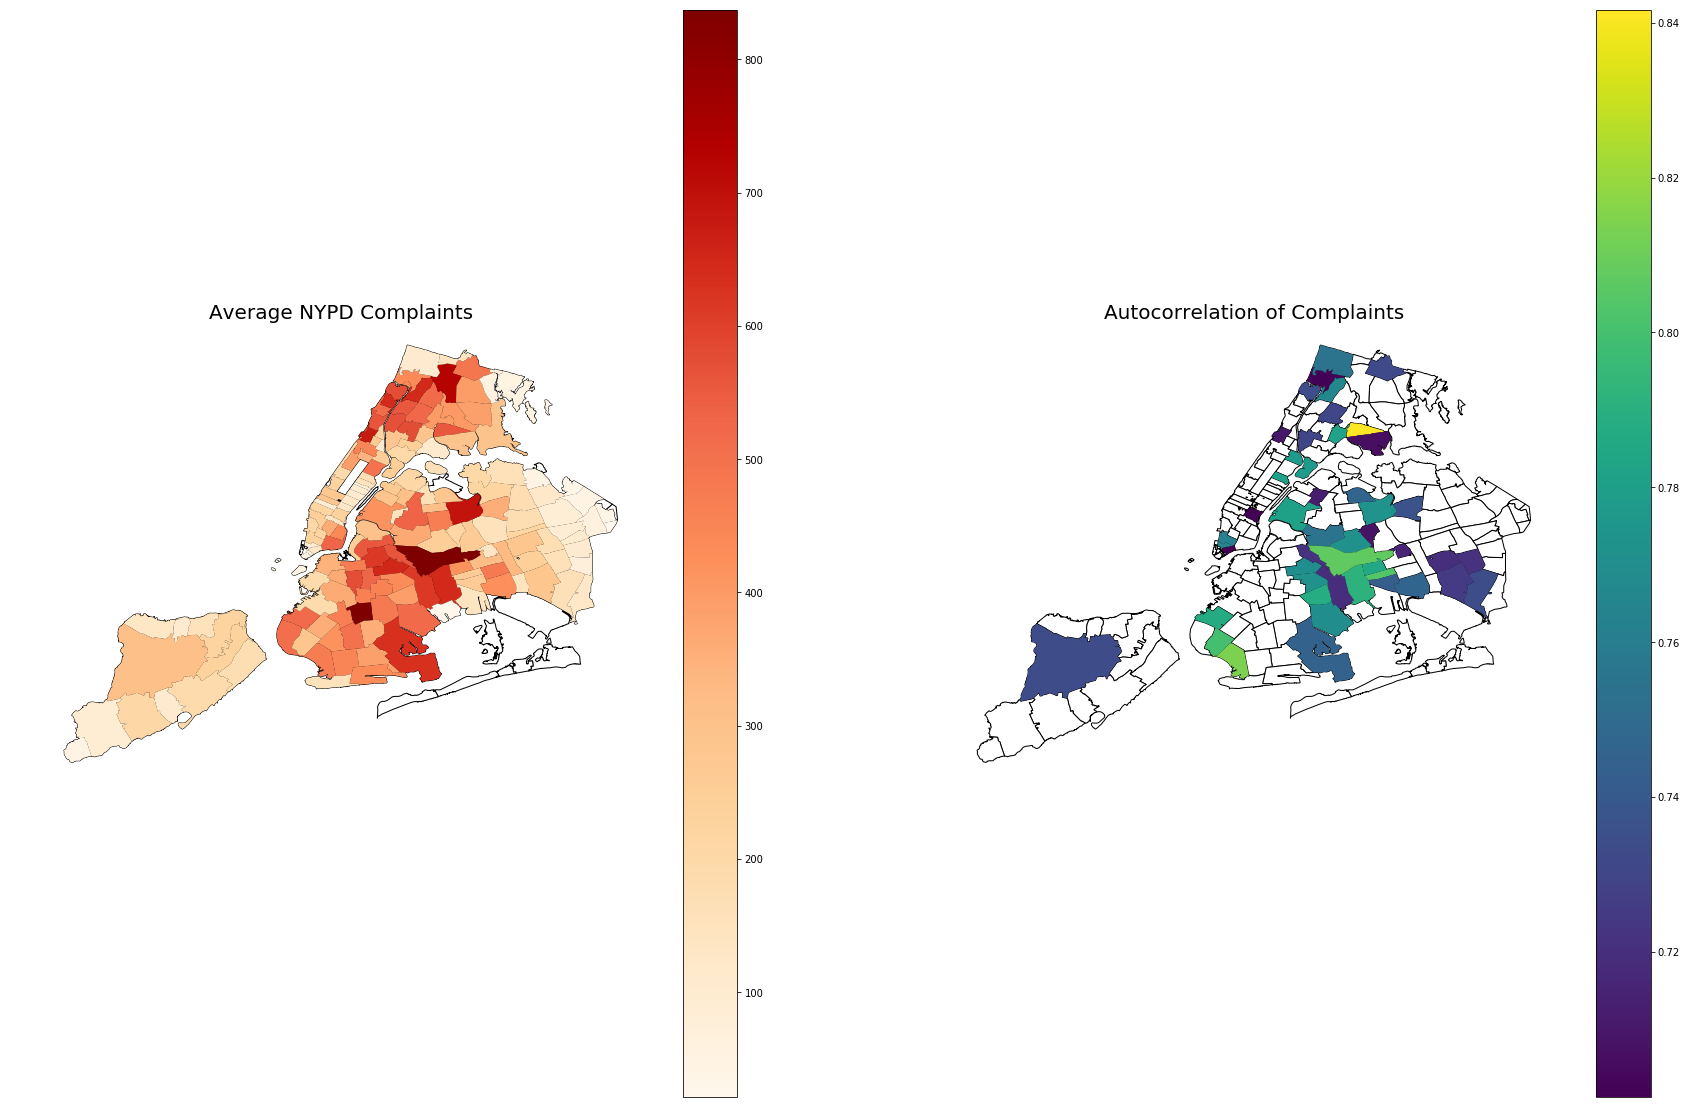

In [15]:
fig = plt.figure(figsize=(30,20))

ax1 = fig.add_subplot(121)
zips.plot(figsize=(20,20), color='white', edgecolor='black', ax=ax1)
nyNYPD.plot(column='averageComplaintsNYPD', ax=ax1, k=10, cmap='OrRd', legend=True)
ax1.set_axis_off()
plt.title('Average NYPD Complaints', fontsize=20)

ax2 = fig.add_subplot(122)
zips.plot(figsize=(20,20), color='white', edgecolor='black', ax=ax2)
nyNYPD1.plot(column='autocorr', ax=ax2, k=10, cmap='viridis', legend=True)
ax2.set_axis_off()
plt.title('Autocorrelation of Complaints', fontsize=20)

## For HPD

In [4]:
with open('ComplaintsHPD_NYC.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    header = ['zip', 'averageComplaintsNYPD', 'autocorr', 'totalComplaints']
    writer.writerow(header)

In [5]:
for zip in nyzips:
    dataTemp = data[(data['Incident Zip'] == zip)]
    
    if len(dataTemp) != 0:
        dataTemp.sort_values(by='Cdate', inplace=True)
    
        y = pd.to_datetime(dataTemp['Cdate'].values)
        dataTemp['month'] = y.strftime("%y-%m")
    
        dataTempNYPD = dataTemp[(dataTemp.Agency == 'HPD')]
        dataTempNYPD = dataTempNYPD.groupby(by='month').count()
    
        dataTempNYPD['month'] = dataTempNYPD.index
        dataTempNYPD.reset_index(drop=True, inplace=True)
    
        y = dataTempNYPD[['Unique Key']]
    
        totalComplaints = y['Unique Key'].sum()
        avgComplaints = y['Unique Key'].sum()/len(y)
        y['lag'] = y['Unique Key'].shift(1)
    
        y.dropna(inplace=True)
        j = y.corr()
        autocorr = j['lag'][0]
    
        temp = [zip, avgComplaints, autocorr, totalComplaints]
    
        with open('ComplaintsHPD_NYC.csv', 'a') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(temp)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in long_scalars
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

In [16]:
nyHPD = pd.read_csv('ComplaintsHPD_NYC.csv')
nyHPD.head()

,zip,averageComplaintsNYPD,autocorr,totalComplaints
0,10000,0,NaN,0
1,10001,75,0.648459,3994
2,10002,287,0.482436,15236
3,10003,225,0.647299,11943
4,10004,3,-0.051738,112


In [17]:
nyHPD = nyHPD[(nyHPD.totalComplaints > 1000)]
nyHPD.shape

(152, 4)

In [18]:
nyHPD = nyHPD.merge(zips, left_on='zip', right_on='ZIPCODE', how='inner')[['zip', 'averageComplaintsNYPD', 
                                                                            'autocorr', 'totalComplaints', 
                                                                            'POPULATION', 'AREA', 'PO_NAME', 'geometry']]
crs = {'init': 'epsg:4326'}
#geometry = [Point(xy) for xy in zip(Sept200rest.longitude, Sept200rest.latitude)]
nyHPD = gpd.GeoDataFrame(nyHPD, crs=crs, geometry='geometry')

In [19]:
nyHPD1 = nyHPD[(nyHPD.autocorr > 0.7)]

Text(0.5,1,'Temporal autocorrelation of Complaints')

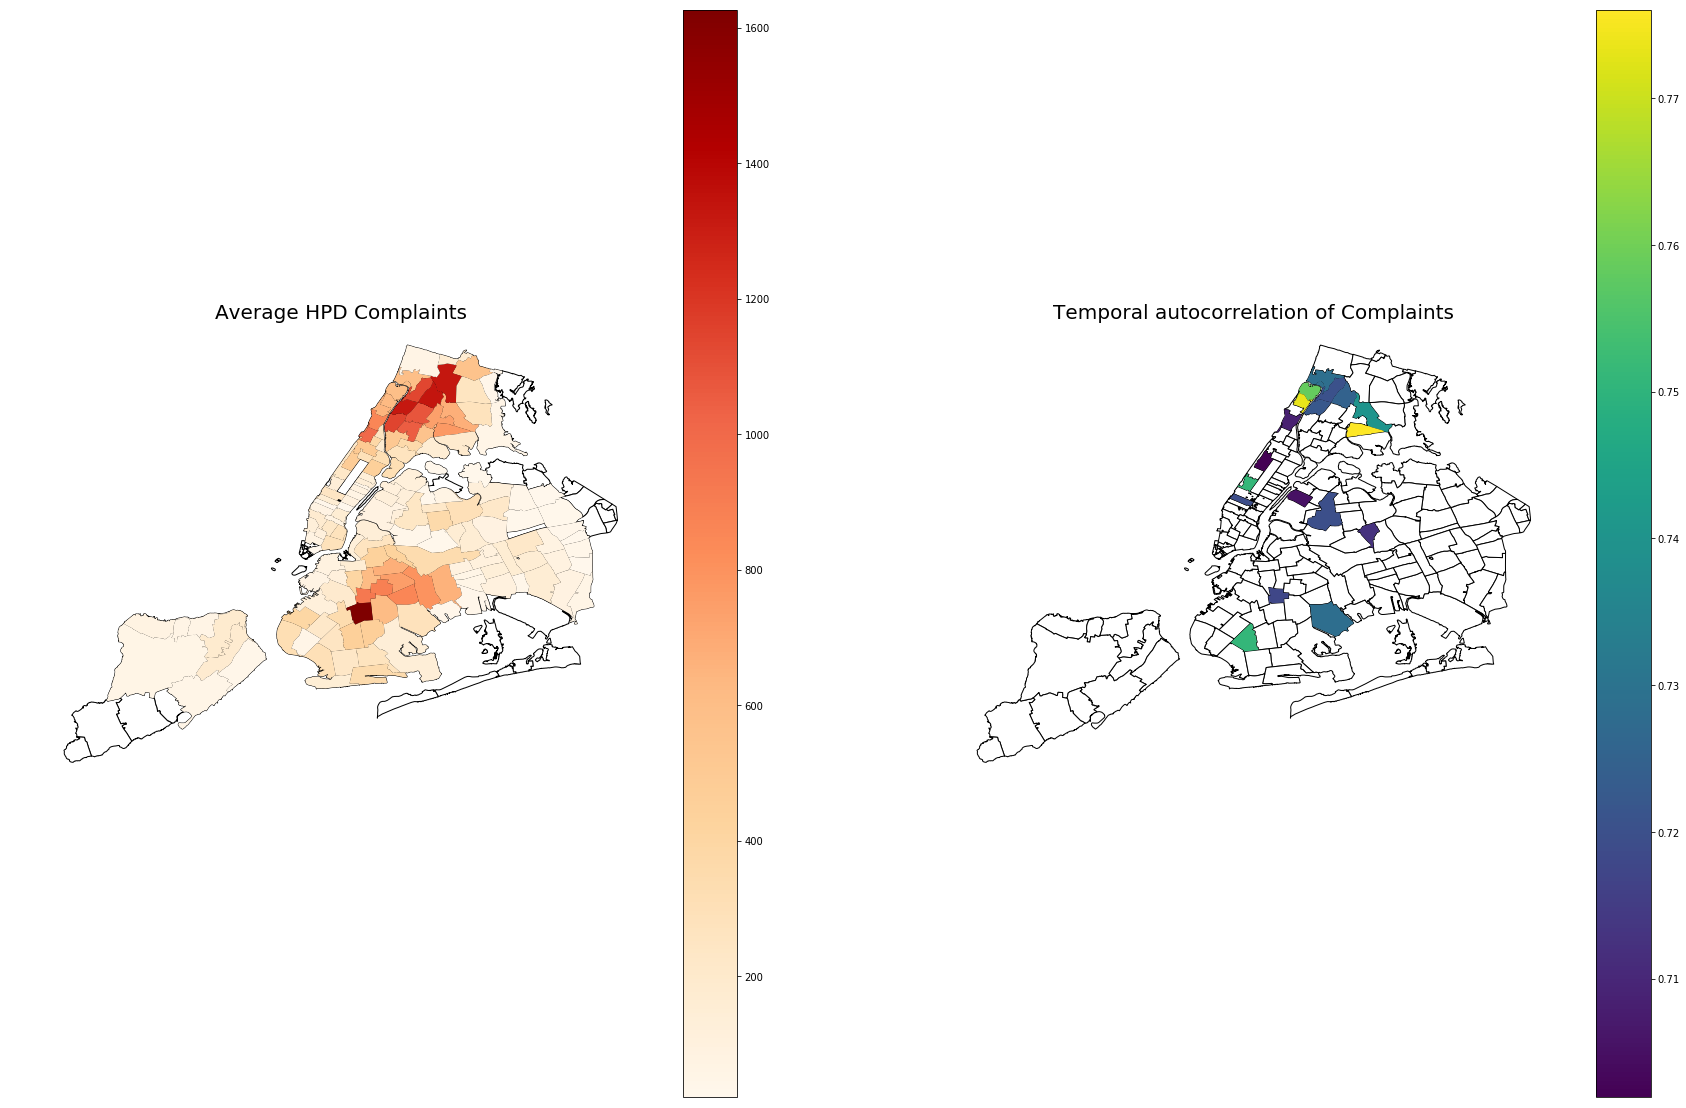

In [20]:
fig = plt.figure(figsize=(30,20))

ax1 = fig.add_subplot(121)
zips.plot(figsize=(20,20), color='white', edgecolor='black', ax=ax1)
nyHPD.plot(column='averageComplaintsNYPD', ax=ax1, k=10, cmap='OrRd', legend=True)
ax1.set_axis_off()
plt.title('Average HPD Complaints', fontsize=20)

ax2 = fig.add_subplot(122)
zips.plot(figsize=(20,20), color='white', edgecolor='black', ax=ax2)
nyHPD1.plot(column='autocorr', ax=ax2, k=10, cmap='viridis', legend=True)
ax2.set_axis_off()
plt.title('Temporal autocorrelation of Complaints', fontsize=20)

## For DEP

In [21]:
with open('ComplaintsDEP_man.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    header = ['zip', 'averageComplaintsNYPD', 'autocorr', 'totalComplaints']
    writer.writerow(header)

In [25]:
for zip in manzips:
    dataTemp = data[(data['Incident Zip'] == zip)]
    
    if len(dataTemp) != 0:
        dataTemp.sort_values(by='Cdate', inplace=True)
    
        y = pd.to_datetime(dataTemp['Cdate'].values)
        dataTemp['month'] = y.strftime("%y-%m")
    
        dataTempNYPD = dataTemp[(dataTemp.Agency == 'HPD')]
        dataTempNYPD = dataTempNYPD.groupby(by='month').count()
    
        dataTempNYPD['month'] = dataTempNYPD.index
        dataTempNYPD.reset_index(drop=True, inplace=True)
    
        y = dataTempNYPD[['Unique Key']]
    
        totalComplaints = y['Unique Key'].sum()
        avgComplaints = y['Unique Key'].sum()/len(y)
        y['lag'] = y['Unique Key'].shift(1)
    
        y.dropna(inplace=True)
        j = y.corr()
        autocorr = j['lag'][0]
    
        temp = [zip, avgComplaints, autocorr, totalComplaints]
    
        with open('ComplaintsDEP_man.csv', 'a') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(temp)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in long_scalars
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

In [26]:
manDEP = pd.read_csv('ComplaintsDEP_man.csv')
manDEP.head()

,zip,averageComplaintsNYPD,autocorr,totalComplaints
0,10000,0,NaN,0
1,10001,75,0.648459,3994
2,10002,287,0.482436,15236
3,10003,225,0.647299,11943
4,10004,3,-0.051738,112


In [27]:
manDEP = manDEP[(manDEP.totalComplaints > 1000)]
manDEP.shape

(36, 4)

In [28]:
manDEP = manDEP.merge(zips, left_on='zip', right_on='ZIPCODE', how='inner')[['zip', 'averageComplaintsNYPD', 
                                                                            'autocorr', 'totalComplaints', 
                                                                            'POPULATION', 'AREA', 'PO_NAME', 'geometry']]
crs = {'init': 'epsg:4326'}
#geometry = [Point(xy) for xy in zip(Sept200rest.longitude, Sept200rest.latitude)]
manDEP = gpd.GeoDataFrame(manDEP, crs=crs, geometry='geometry')

In [32]:
manDEP1 = manDEP[(manDEP.autocorr > 0.65)]

Text(0.5,1,'Autocorrelation of Complaints')

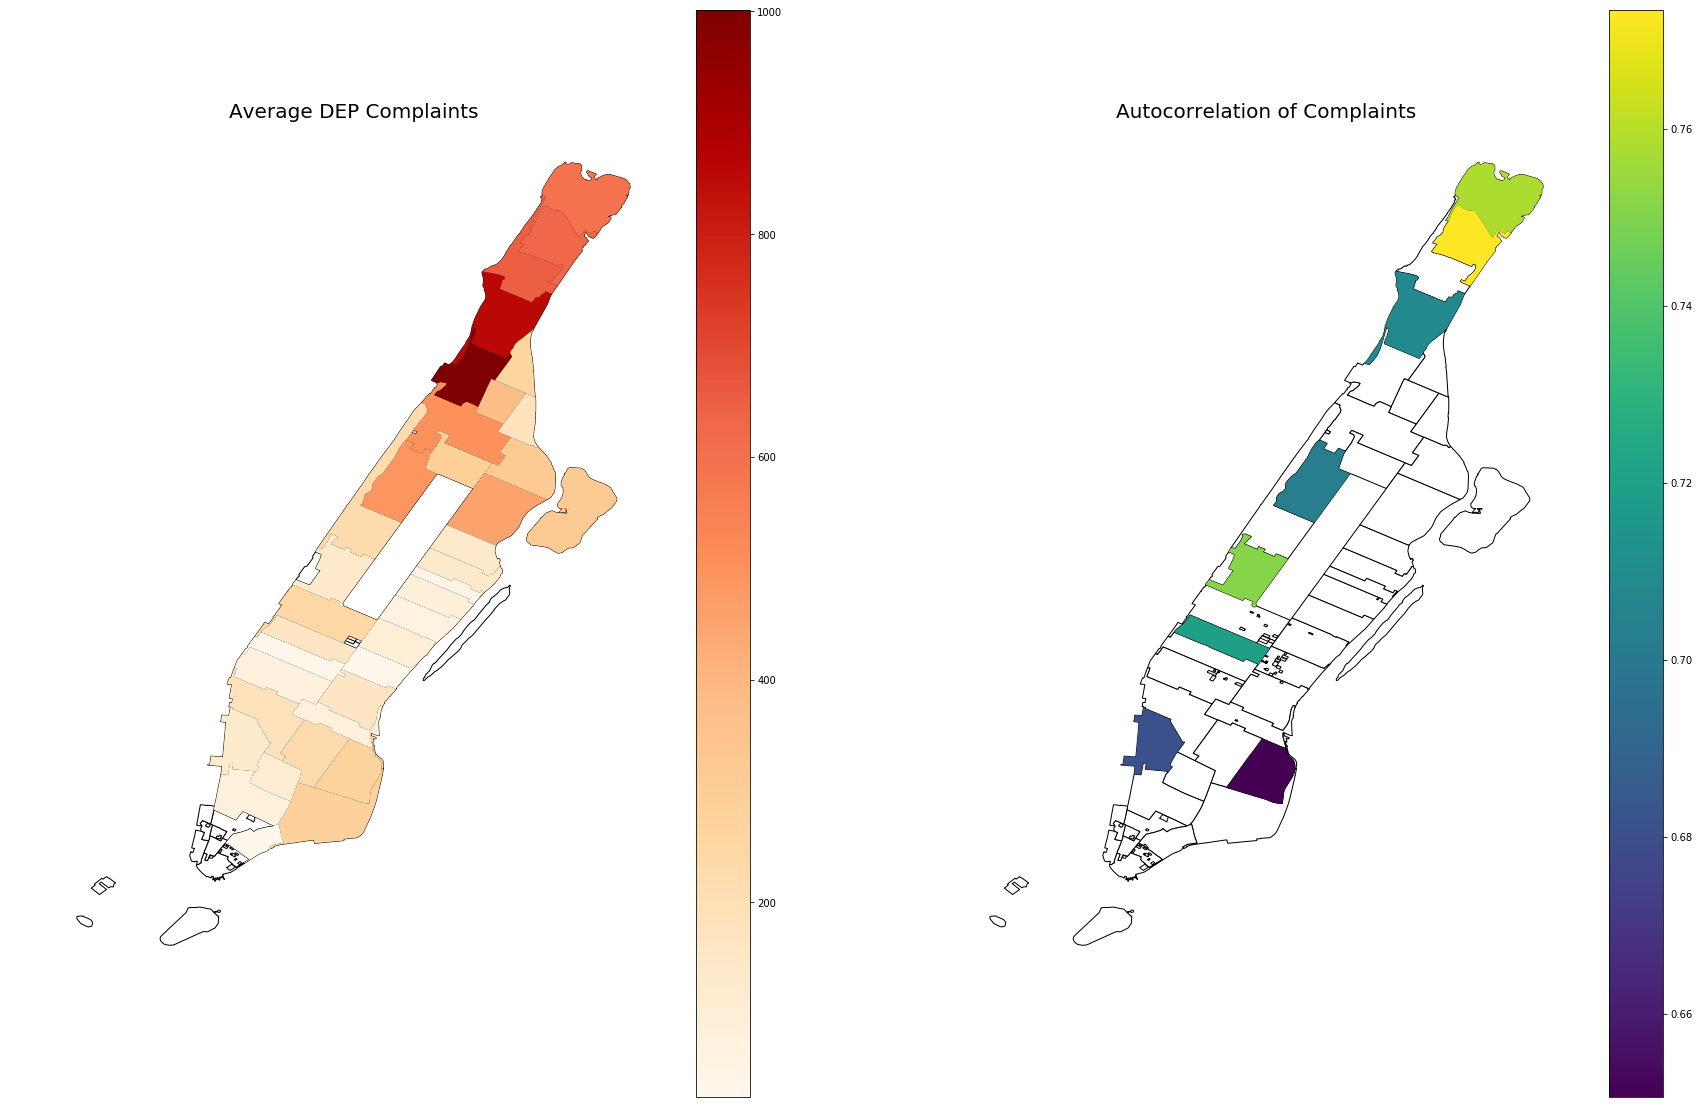

In [36]:
fig = plt.figure(figsize=(30,20))

ax1 = fig.add_subplot(121)
zipsMan.plot(figsize=(20,20), color='white', edgecolor='black', ax=ax1)
manDEP.plot(column='averageComplaintsNYPD', ax=ax1, k=10, cmap='OrRd', legend=True)
ax1.set_axis_off()
plt.title('Average DEP Complaints', fontsize=20)

ax2 = fig.add_subplot(122)
zipsMan.plot(figsize=(20,20), color='white', edgecolor='black', ax=ax2)
manDEP1.plot(column='autocorr', ax=ax2, k=10, cmap='viridis', legend=True)
ax2.set_axis_off()
plt.title('Autocorrelation of Complaints', fontsize=20)